In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from random import shuffle
import skimage
from tqdm.notebook import trange, tqdm
from multiprocessing import Pool


rng = np.random.default_rng()

In [2]:
def gen_lattice(p, L):
  return rng.choice([1, 0], p = [p, 1-p], size=(L,L))

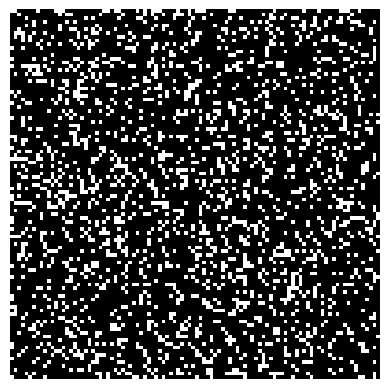

In [8]:
grid = gen_lattice(0.8, 100)
plt.imshow(grid, cmap="Greys")
plt.axis("off")
plt.savefig("percolation_grid_08.png", bbox_inches="tight", pad_inches=0, dpi=500)

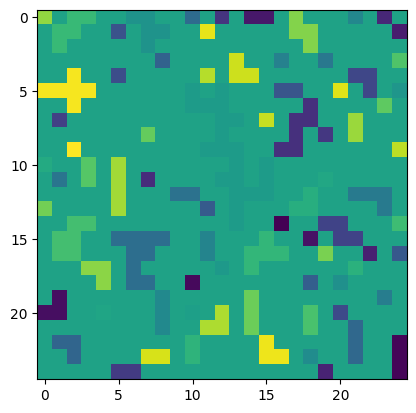

In [ ]:
grid = gen_lattice(0.3, 25)

labels, num = skimage.measure.label(grid, return_num=True, connectivity=1)

b = np.arange(labels.max() + 1)
shuffle(b)
labels = b[labels]
plt.imshow(labels)


In [3]:
def has_spanning_cluster(grid):
  lw, num = sc.ndimage.label(grid)
  isection = np.intersect1d(lw[0,:], lw[-1,:])
  perc = isection[np.where(isection>0)]
  return len(perc) > 0

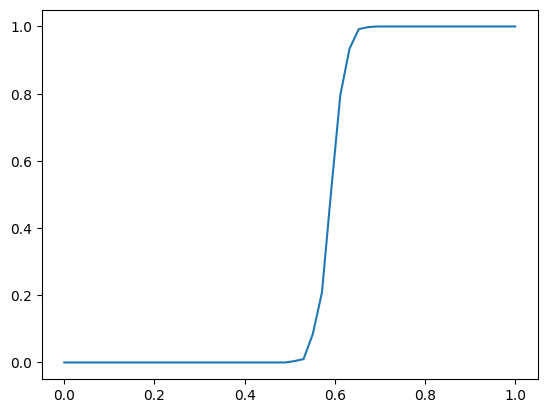

In [ ]:
L = 200
num_trials = 500

ps = np.linspace(0, 1, 50)
perc_hist = np.zeros(len(ps))

for i in range(len(ps)):
  num_percs = 0
  for j in range(num_trials):
    if has_spanning_cluster(gen_lattice(ps[i], 50)):
      num_percs += 1
  perc_hist[i] = num_percs / num_trials

plt.plot(ps, perc_hist)

In [4]:
def filter_largest_cluster(lattice):
  labels, num = skimage.measure.label(lattice, return_num=True, connectivity=1)
  rps = skimage.measure.regionprops(labels)
  max_size = max([i.area for i in rps])
  out = skimage.morphology.remove_small_objects(labels, min_size = max_size)

  out[np.where(out>0)] = 1

  return out

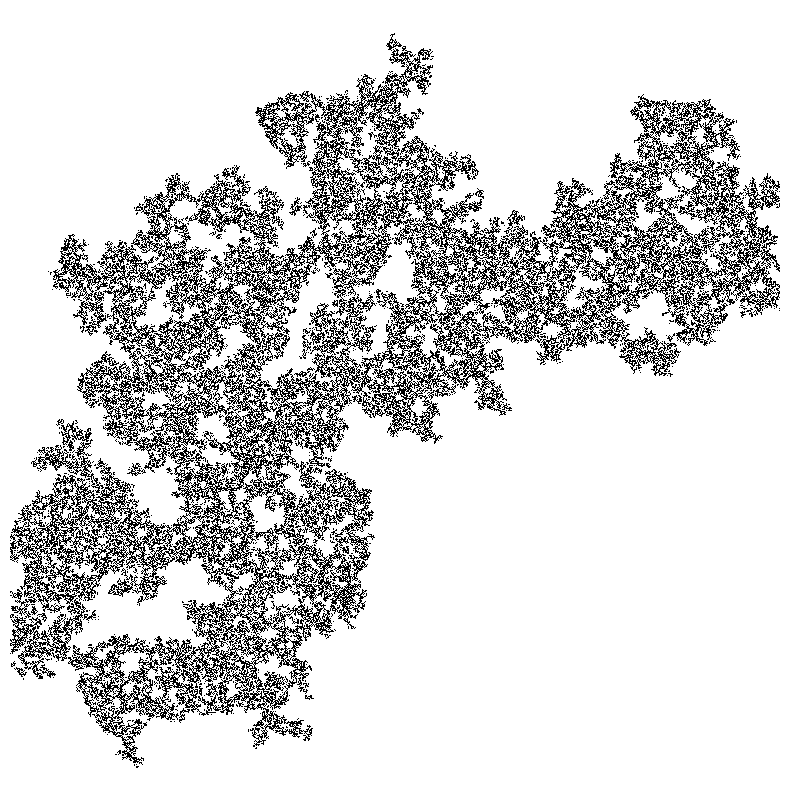

In [28]:
L = 3000
pc = 0.5927

fig, ax = plt.subplots()
lattice = gen_lattice(pc, L)

lattice = filter_largest_cluster(lattice)

ax.imshow(lattice, cmap="Greys", interpolation="none")
ax.axis("off")

fig.set_size_inches(10, 10)




In [29]:
fig.savefig("fractal_cluster.png", bbox_inches="tight", pad_inches=0, dpi=400)

In [5]:
def identify_clusters(lattice):
    structure = np.array([[0, 1, 0],
                          [1, 1, 1],
                          [0, 1, 0]])
    labeled_lattice, num_features = sc.ndimage.label(lattice, structure=structure)
    return labeled_lattice, num_features

def highlight_largest_cluster(lattice, labeled_lattice, num_features):
    max_size = 0
    largest_cluster_label = 0
    for i in range(1, num_features + 1):
        cluster_size = np.sum(labeled_lattice == i)
        if cluster_size > max_size:
            max_size = cluster_size
            largest_cluster_label = i

    highlighted_lattice = np.zeros((lattice.shape[0], lattice.shape[1], 3))
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if labeled_lattice[i, j] == largest_cluster_label:
                highlighted_lattice[i, j] = [1, 0,0]  # Red for the largest cluster #186,255,201
            elif lattice[i, j]:
                highlighted_lattice[i, j] = [0, 0, 0]  # Black for other occupied sites
            else:
                highlighted_lattice[i, j] = [1, 1, 1]  # White for unoccupied sites

    return highlighted_lattice

def plot_lattice(highlighted_lattice):
    plt.imshow(highlighted_lattice, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()




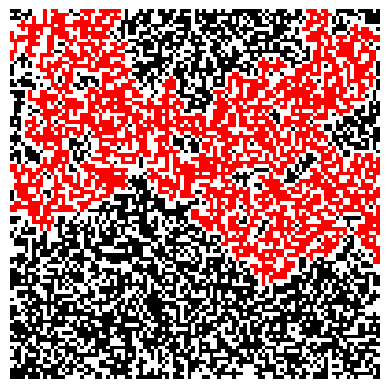

In [12]:
L = 100
ls = [100]
ps = [0.593]



fig, ax = plt.subplots(1, len(ps))
for i in range(len(ps)):
  L = ls[i]
  lattice = gen_lattice(ps[i], L)
  labeled_lattice, num_features = identify_clusters(lattice)
  highlighted_lattice = highlight_largest_cluster(lattice, labeled_lattice, num_features)

  ax.imshow(highlighted_lattice, cmap="gray", interpolation="nearest")
  ax.axis("off")


#fig.set_size_inches(100, 100)



# Plot the lattice with the largest cluster highlighted




In [ ]:
fig.savefig("cluster_highlighted500.png", bbox_inches="tight", pad_inches=0, dpi=1400)

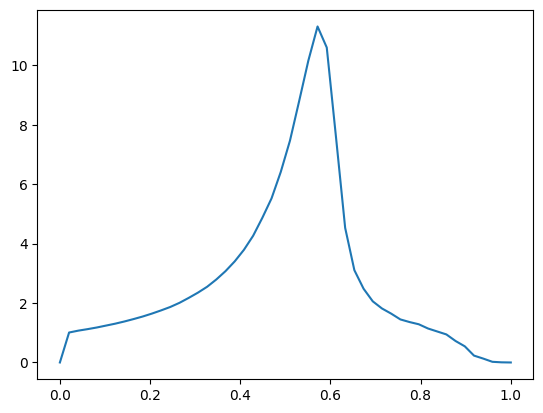

In [ ]:
L = 100
num_trials = 200

ps = np.linspace(0, 1, 50)
clust_sizes = np.zeros(len(ps))

for i in range(len(ps)):
  num_percs = 0
  for j in range(num_trials):
    lattice = gen_lattice(ps[i], L)
    lw, num = skimage.measure.label(lattice, return_num=True, connectivity=1)


    cluster_sizes = sc.ndimage.sum_labels(lattice, lw, index=np.arange(lw.max() + 1))

    # Identify the largest cluster
    largest_cluster_id = np.argmax(cluster_sizes)


    finite_cluster_sizes = cluster_sizes[cluster_sizes != cluster_sizes[largest_cluster_id]]

    if len(finite_cluster_sizes) > 0:
        mean_finite_cluster_size = np.mean(finite_cluster_sizes)
    else:
        mean_finite_cluster_size = 0

    clust_sizes[i] += mean_finite_cluster_size / num_trials


plt.plot(ps, clust_sizes)

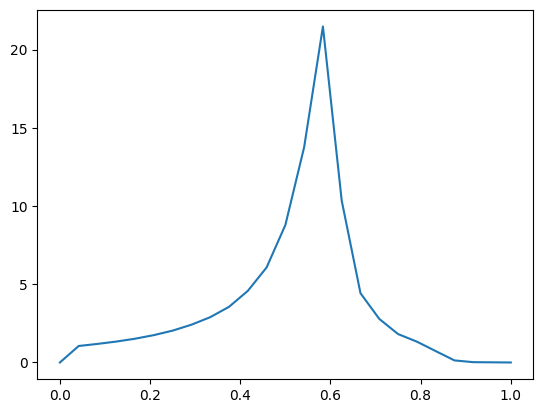

In [ ]:
L = 100
num_trials = 100

ps = np.linspace(0, 1, 25)
corr_lengths = np.zeros(len(ps))

for i in range(len(ps)):
  num_percs = 0
  for j in range(num_trials):
    lattice = gen_lattice(ps[i], L)
    lw, num = skimage.measure.label(lattice, return_num=True, connectivity=1)


    cluster_sizes = sc.ndimage.sum_labels(lattice, lw, index=np.arange(lw.max() + 1))

    # Identify the largest cluster
    largest_cluster_id = np.argmax(cluster_sizes)


    coords = np.column_stack(np.where(lattice == 1))

    total_distance = 0
    total_pairs = 0

    for cluster_id in range(1, num + 1):
        if cluster_id == largest_cluster_id:
          continue
        cluster_coords = coords[lw[coords[:, 0], coords[:, 1]] == cluster_id]

        # Compute all pairwise distances in the cluster using vectorized operations
        if len(cluster_coords) > 1:
            diffs = cluster_coords[:, np.newaxis, :] - cluster_coords[np.newaxis, :, :]
            sq_dists = np.sum(diffs**2, axis=2)
            total_distance += np.sum(sq_dists) / 2  # Each pair is counted twice
            total_pairs += len(cluster_coords) * (len(cluster_coords) - 1) / 2

    if total_pairs > 0:
        mean_squared_distance = total_distance / total_pairs
    else:
        mean_squared_distance = 0

    correlation_length = np.sqrt(mean_squared_distance)
    corr_lengths[i] += correlation_length / num_trials



plt.plot(ps, corr_lengths)

In [6]:
def coarse_grain(grid, avg=False):
  # takes in NxN grid and returns coarse-grained smaller grid (using majority rule)
  N = len(grid)
  out_grid = np.zeros((N//2, N//2), dtype=np.int32)

  for i in range(N//2):
    for j in range(N//2):
      s = 0

      if avg:
        for k in range(2):
          for l in range(2):
            if grid[i*2 + k][j*2 + l] == 1:
              s += 1
            else:
              s -= 1
      else:
        if grid[i*2][j*2] and grid[i*2 + 1][j*2]:
          s = 1
        elif grid[i*2][j*2 + 1] and grid[i*2 + 1][j*2 + 1]:
          s = 1
        else:
          s = -1

      if s > 0:
        out_grid[i][j] = 1
      elif s < 0:
        out_grid[i][j] = 0
      else:
        out_grid[i][j] = rng.choice([1, 0])
  return out_grid




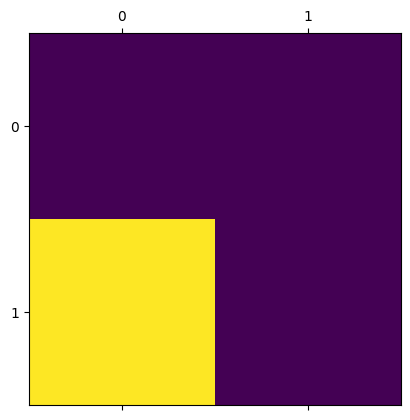

In [ ]:
lattice = [[0, 0],
            [1, 0]]

plt.matshow(lattice)
c

In [7]:
def isolate_largest_cluster(lattice, labeled_lattice, num_features):
    max_size = 0
    largest_cluster_label = 0
    for i in range(1, num_features + 1):
        cluster_size = np.sum(labeled_lattice == i)
        if cluster_size > max_size:
            max_size = cluster_size
            largest_cluster_label = i

    highlighted_lattice = np.zeros((lattice.shape[0], lattice.shape[1]))
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if labeled_lattice[i, j] == largest_cluster_label:
                highlighted_lattice[i, j] = 1  # Red for the largest cluster #186,255,201
            else:
                highlighted_lattice[i, j] = 0  # White for unoccupied sites

    return highlighted_lattice

def merge_lattices(orig_lattice, highlighted):
    out_lattice = np.zeros((orig_lattice.shape[0], orig_lattice.shape[1], 3))
    for i in range(orig_lattice.shape[0]):
        for j in range(orig_lattice.shape[1]):
            if highlighted[i, j] > 0.5:
                out_lattice[i, j] = [1, 0,0]  # Red for the largest cluster #186,255,201
            elif orig_lattice[i, j] > 0.5:
                out_lattice[i, j] = [0, 0, 1]  # Black for other occupied sites
            else:
                out_lattice[i, j] = [1, 1, 1]  # White for unoccupied sites
    return out_lattice

def renormalization(p, L, num_coarses=4, hl=False):
    fig, ax = plt.subplots(num_coarses+1, 1)
    lattice = gen_lattice(p, L)
    orig_lattice = lattice
    
    labels, num_features =  identify_clusters(lattice)
    if hl:
        highlighted_lattice = isolate_largest_cluster(lattice, labels, num_features)
    else:
        highlighted_lattice = np.zeros((lattice.shape[0], lattice.shape[1]))
    

    merged = merge_lattices(orig_lattice, highlighted_lattice)

    lattice = highlighted_lattice
    lattices = [merged]

    for i in range(num_coarses):
        new_orig = coarse_grain(coarse_grain(orig_lattice))
        new_lattice = coarse_grain(coarse_grain(lattice))
        # labels, num_features =  identify_clusters(new_lattice)
        # highlighted_lattice = highlight_largest_cluster(new_lattice, labels, num_features)
        merged_new = merge_lattices(new_orig, new_lattice)
        lattices.append(merged_new)
        orig_lattice = new_orig
        lattice = new_lattice


    for i in range(num_coarses+1):
        ax[i].imshow(lattices[i], interpolation="none")
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    #fig.set_size_inches(20, 20)
    
    fig.savefig(f"renorm_clusters_L{L}_p{p}.png", bbox_inches="tight", pad_inches=0, dpi=600)




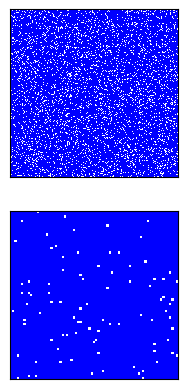

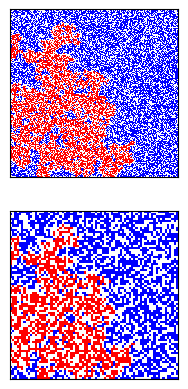

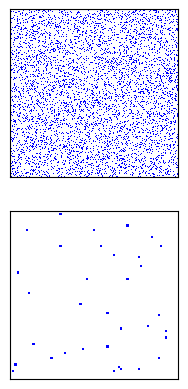

In [44]:
renormalization(0.87,   300, 1, hl = False)
renormalization(0.593, 300, 1, hl = True)
renormalization(0.1719,   300, 1, hl = False)


# Transformation is going top->bottom only using yellow

In [15]:
def renormalization_fractal_dimension(p, L):
  lattice = gen_lattice(p, L)
  m_squared = np.sum(filter_largest_cluster(lattice))

  #print(m_squared)
  #fig, ax = plt.subplots(1,2)
  #ax[0].imshow(filter_largest_cluster(lattice))

  coarse_lattice = coarse_grain(filter_largest_cluster(lattice), avg=True)

  coarse_m_squared = np.sum(coarse_lattice)


  #print(coarse_m_squared)
  #ax[1].imshow(coarse_lattice)


  return np.log2(m_squared / coarse_m_squared)


In [16]:
renormalization_fractal_dimension(0.5927, 100)

# Should be D = 91/48 ≈ 1.896
# Fractals - Jens Feder

1.871976698567364

In [17]:
num_iterations = 100
avg_d = 0

for i in tqdm(range(num_iterations)):
  cur_d = renormalization_fractal_dimension(0.5927, 500)
  avg_d += cur_d

avg_d /= num_iterations
print(avg_d)


1.8929421164022202


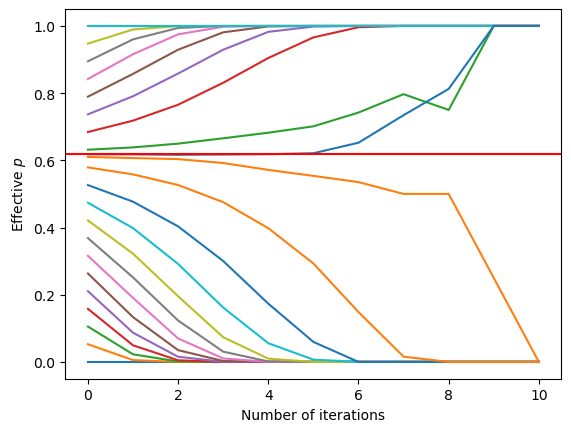

In [48]:
L = 2**10
num_ps = 20
iterations = 10
ps = np.linspace(0, 1, num_ps)

ms = np.zeros(iterations+1)

fig, ax = plt.subplots()

for p in ps:
  lattice = gen_lattice(p, L)
  ms[0] = p
  for i in range(iterations):
    lattice = coarse_grain(lattice)
    ms[i+1] = lattice.sum() / lattice.size
  ax.plot(np.arange(iterations+1), ms)


ps = [0.61803, 0.61] #np.linspace(0.55, 0.65, 10)
#ps.append()

ms = np.zeros(iterations+1)


for p in ps:
  lattice = gen_lattice(p, L)
  ms[0] = p
  for i in range(iterations):
    lattice = coarse_grain(lattice)
    ms[i+1] = lattice.sum() / lattice.size
  ax.plot(np.arange(iterations+1), ms)

ax.axhline(y = 0.618, color="r")

ax.set_xlabel("Number of iterations")
ax.set_ylabel(r"Effective $p$")

fig.savefig("cluster_highlighted500.png", bbox_inches="tight", pad_inches=0, dpi=1400)

# Estimating $R_b$ using monte-carlo techniques


In [8]:


def add_random_point(lattice, b, empty_points):
  x, y = empty_points[-1]
  empty_points.pop()
  lattice[x,y] = 1






  """
  x, y = rng.choice(list(range(b))), rng.choice(list(range(b)))
  while lattice[x, y] == 1:
     x, y = rng.choice(list(range(b))), rng.choice(list(range(b)))
  lattice[x,y] = 1

  """

def estimate_s(b):
  lattice = np.zeros((b,b))
  empty_points = [(x, y) for x in range(b) for y in range(b)]
  shuffle(empty_points)
  s = 0
  while s < b:
     add_random_point(lattice, b, empty_points)
     s += 1


  while not has_spanning_cluster(lattice):
    add_random_point(lattice, b, empty_points)
    s += 1

  return s


In [9]:
def calc_sn(b, num_iterations=1000000, normalise = True):
  hist = np.zeros(b*b + 1, dtype=np.longdouble)
  print("calcsn ", b)
  num_iterations = int(num_iterations // (b*b))
  for it in tqdm(range(num_iterations)):
    s = estimate_s(b)
    hist[s] += 1

  for i in range(b*b):
    hist[i+1] += hist[i]
    if normalise:
      hist[i] /= num_iterations
  if normalise:
    hist[b*b] /= num_iterations
  return hist

#plt.plot(calc_sn(2))



In [12]:
coeffs = {}

def calc_r_coeffs(b, num_iterations=1000000, recalculate=True):
  if b in coeffs:
    return coeffs[b]
  sn_hist = calc_sn(b, num_iterations, normalise=True)

  N = b*b
  r_coeffs = np.zeros(N+1, dtype=np.longdouble)
  for i in range(1, N+1):
    r_coeffs[i] = sn_hist[i]  * np.longdouble(sc.special.comb(N, i, exact=True)) # / num_iterations

  coeffs[b] = r_coeffs
  return r_coeffs

In [ ]:
calc_r_coeffs(2)

calcsn  2


  0%|          | 0/25000 [00:00<?, ?it/s]

array([0.    , 0.    , 2.0052, 4.    , 1.    ], dtype=float128)

In [10]:
def R(p, b, coeffs=[], multiprocessing=False, recalculate=False):
  #my_coeffs = []
  #if multiprocessing:
    #my_coeffs = coeffs[b-2]

  if len(coeffs) == 0:
    coeffs = calc_r_coeffs(b)

  N = coeffs.size - 1

  result = 0
  for n in range(1,N+1):
    result += coeffs[n] * p**n * (1-p)**(N-n)

  return result


In [ ]:
b = 4

calc_r_coeffs(b)
#print(coeffs)

print(sc.optimize.fixed_point(R, 0.6, args=(b, coeffs[b])))

calcsn  4


  0%|          | 0/6250 [00:00<?, ?it/s]

0.61930060086592834105


In [ ]:
print(sc.optimize.fixed_point(R, [0.59, 0.6], args=(b, coeffs)))

[0.60388523 0.60388523]


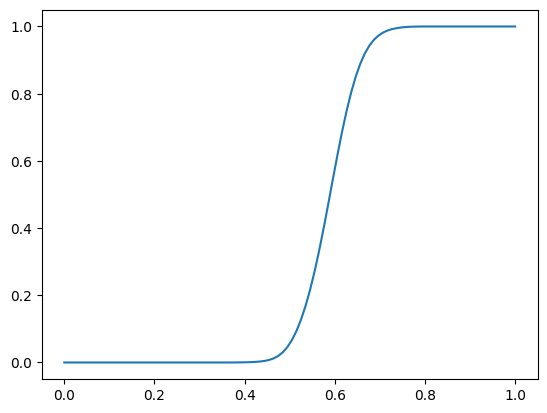

In [ ]:
xs = np.linspace(0, 1, 100)
ys = [R(x, b, coeffs) for x in xs]
plt.plot(xs, ys)

  0%|          | 0/11 [00:00<?, ?it/s]

[array(0.61774333, dtype=float64), array(0.6183357, dtype=float64), array(0.6192092, dtype=float64), array(0.6188351, dtype=float64), array(0.61758596, dtype=float64), array(0.61640512, dtype=float64), array(0.610985, dtype=float64), array(0.60576476, dtype=float64), array(0.60544704, dtype=float64), array(0.60312249, dtype=float64), array(0.60185143, dtype=float64)]


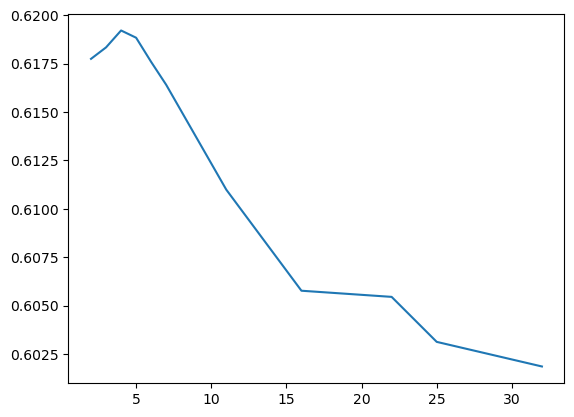

In [20]:
bs = [2,3,4,5,6,7, 11, 16, 22, 25, 32]
ps = []

def funR(b):
  return sc.optimize.fixed_point(R, 0.6, args=(b, []))

#with Pool() as p:
  #coeffs = p.map(calc_r_coeffs, bs)
  #ps = p.map(funR, bs)

for i in tqdm(range(len(bs))):
  coeffs[bs[i]] = calc_r_coeffs(bs[i])
  ps.append(sc.optimize.fixed_point(R, 0.6, args=(bs[i], coeffs[bs[i]])))

#coeffs.insert(0, [])
#coeffs.insert(0, [])


#print(coeffs)
print(ps)
plt.plot(bs, ps)

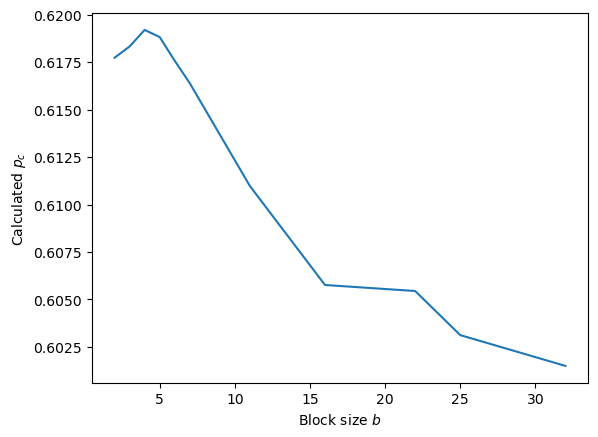

In [45]:
fig, ax = plt.subplots()
ax.plot(bs, ps)
ax.set_xlabel(r"Block size $b$")
ax.set_ylabel(r"Calculated $p_c$")

fig.savefig("pc_vs_b.png", bbox_inches="tight", pad_inches=0, dpi=1400)

In [58]:
del coeffs[32]
coeffs[32] = calc_r_coeffs(32, num_iterations=100000000)
p32 = sc.optimize.fixed_point(R, 0.6, args=(32, coeffs[32]))
print(p32)
ps[-1]= p32

calcsn  32


  0%|          | 0/97656 [00:00<?, ?it/s]

0.6018419739203491


[array(0.61774333, dtype=float64), array(0.6183357, dtype=float64), array(0.6192092, dtype=float64), array(0.6188351, dtype=float64), array(0.61758596, dtype=float64), array(0.61640512, dtype=float64), array(0.610985, dtype=float64), array(0.60576476, dtype=float64), array(0.60544704, dtype=float64), array(0.60312249, dtype=float64), array(0.60149861, dtype=float64)]


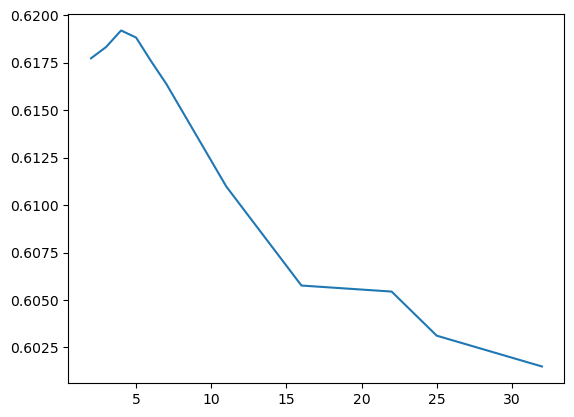

In [44]:
plt.plot(bs, ps)
print(ps)

In [29]:
def derivative(f, x, h = 0.0001):
  return (f(x + h) - f(x - h))/(2*h)


In [30]:
pc = 0.59899179

R_lambda = lambda x : R(x, 5, coeffs[5-2])

lamb = derivative(R_lambda, pc)
print(lamb)

1.9900926839339084


In [62]:
bs = [2,3,4,5,6,7, 11, 16, 22, 25, 32]
def get_nu(b):
  pc = sc.optimize.fixed_point(R, 0.6, args=(b, coeffs[b]))

  R_lambda = lambda x : R(x, b, coeffs[b])
  lamb = derivative(R_lambda, pc)

  return np.log(b) / np.log(lamb)


nus = []
for b in bs:
  nus.append(get_nu(b))
print(nus)

[1.6356259681044498, 1.6227179406798762, 1.6061483636430378, 1.5951059706815744, 1.5749709158563687, 1.5659140875696826, 1.5469978085158702, 1.5277878374770162, 1.4965190665519585, 1.5027232235966992, 1.4939740401540214]


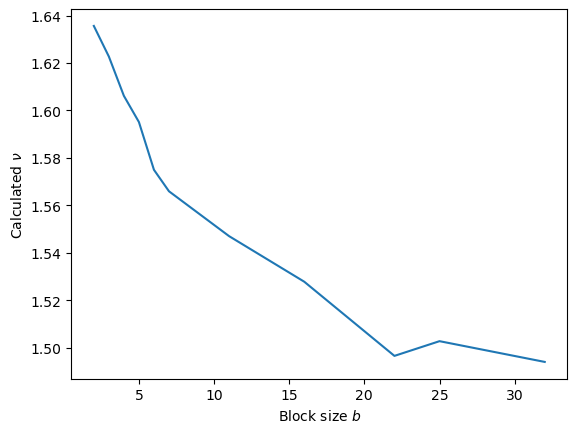

In [65]:
fig, ax = plt.subplots()

ax.set_xlabel(r"Block size $b$")
ax.set_ylabel(r"Calculated $\nu$")
ax.plot(bs, nus)
fig.savefig("nu_vs_b.png", bbox_inches="tight", pad_inches=0, dpi=1400)

In [ ]:
lambdas = [1, 1]

for i in range(len(bs)):
  R_lambda = lambda x : R(x, bs[i], coeffs[bs[i]])
  lambdas.append(derivative(R_lambda, ps[bs[i]-2]))

print(lambdas)

[1, 1, 1.5420211500642696664, 1.9901785285457569783, 2.3810136650474429663, 2.7550349876844669138, 3.075682632147751362, 3.4299938671145716543, 3.8687641702570117134, 3.985943378735330054, 4.5801930103475078228, 4.662067672742545683, 5.058365689690768931, 5.313090046403373695, 5.4124150712260121437]


In [35]:
def get_nu_b1b2(b1, b2):
  # Go from b1 -> b2 length blocks, so b1 < b2
  pc = 0.5927
  #pc1 = ps[b1-2]
  R_lambda1 = lambda x : R(x, b1)  # , coeffs[b1]
  l1 = derivative(R_lambda1, pc)

  #pc2 = ps[b2-2]
  R_lambda2 = lambda x : R(x, b2)  # , coeffs[b2]
  l2 = derivative(R_lambda2, pc)


  return np.log(b1 / b2) / np.log(l1 / l2)




In [ ]:
print(get_nu_b1b2(31,32))

0.629416777511592024


calcsn  1


  0%|          | 0/1000000 [00:00<?, ?it/s]

calcsn  10


  0%|          | 0/10000 [00:00<?, ?it/s]

calcsn  15


  0%|          | 0/4444 [00:00<?, ?it/s]

calcsn  21


  0%|          | 0/2267 [00:00<?, ?it/s]

calcsn  24


  0%|          | 0/1736 [00:00<?, ?it/s]

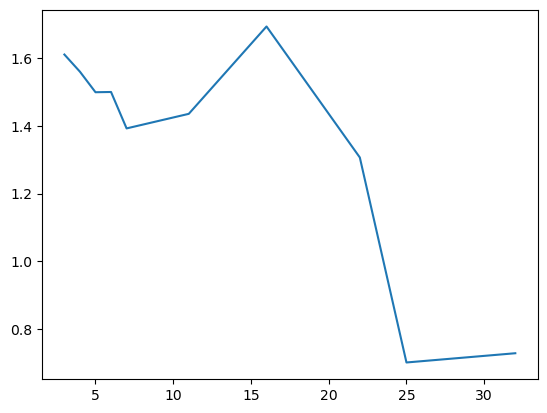

In [39]:
nu_b1b2 = []

for i in range(len(bs)-1):
  nu_b1b2.append(get_nu_b1b2(bs[i], bs[i]-1))

plt.plot(bs[1:], nu_b1b2)

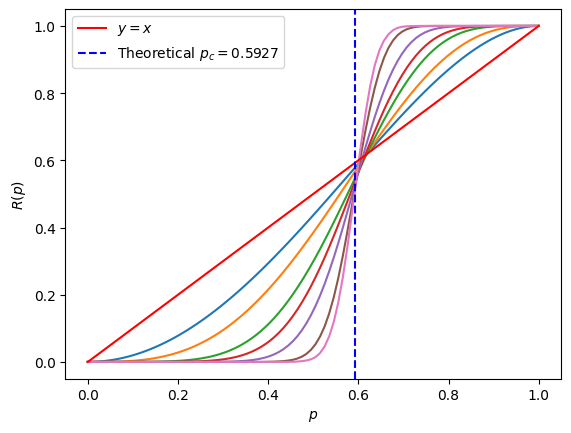

In [14]:
bs = [2,3,5,7, 11,  22, 32]
ps = np.linspace(0,1,100)

fig, ax = plt.subplots()
for b in bs:
  ax.plot(ps, R(ps, b))

ax.plot([0,1], [0,1], "r-", label=r"$y=x$")


ax.axvline(x = 0.5927, color="blue", linestyle="dashed", label=r"Theoretical $p_c = 0.5927$")

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$R(p)$")

ax.legend(loc="upper left")

fig.savefig("Rbs.png", bbox_inches="tight", pad_inches=0, dpi=1400)

calcsn  3


  0%|          | 0/55555 [00:00<?, ?it/s]

calcsn  2


  0%|          | 0/125000 [00:00<?, ?it/s]

calcsn  4


  0%|          | 0/31250 [00:00<?, ?it/s]

calcsn  5


  0%|          | 0/20000 [00:00<?, ?it/s]

calcsn  6


  0%|          | 0/13888 [00:00<?, ?it/s]

calcsn  7


  0%|          | 0/10204 [00:00<?, ?it/s]

calcsn  8


  0%|          | 0/7812 [00:00<?, ?it/s]

calcsn  17


  0%|          | 0/1730 [00:00<?, ?it/s]

calcsn  16


  0%|          | 0/1953 [00:00<?, ?it/s]

[1.5544426140357688779, 1.5035624134801349154, 1.5645561215800997919, 1.4058087768333668944, 1.4401013842143999362, 1.5466124193759066808, 0.93930655910467976524]


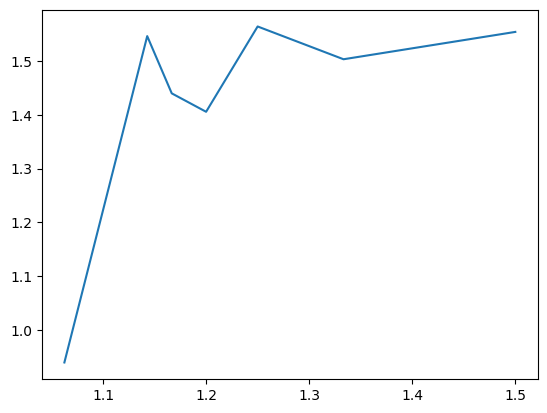

In [ ]:
bs = [2,3,4,5,6,7, 16]
ratios = []
nus = []
for b in bs:
  nus.append(get_nu_b1b2(b+1, b))
  ratios.append((b+1)/b)

print(nus)
plt.plot(ratios, nus)